In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FuncLaserScattering import delete_distance, smoothing_apple, skip_distance

from scipy.optimize import curve_fit, minimize_scalar
from scipy import signal
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
total_df = pd.read_csv('./../data/Profile_all.csv')

# 距離と輝度（強度）を分割
distance = total_df.iloc[:,0]
apple_df = total_df.drop('distance (mm)',axis=1)


#####解析範囲外の領域を削除#####
distance_30mm, apple_df_30mm = delete_distance(distance, apple_df)


#####プロファイルの平滑化#####
distance_smooth, apple_smooth = smoothing_apple(distance_30mm, apple_df_30mm)


#####プロファイルの間引き (1mm間隔)#####
distance_eq, apple_smooth_eq = skip_distance(distance_smooth, apple_smooth)

/Users/daiki/python_enviroment/MasterDegree/Chapter5_2/code/FuncLaserScattering.py:122: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_df_eq = apple_df_eq.interpolate('ffill')
/Users/daiki/python_enviroment/MasterDegree/Chapter5_2/code/FuncLaserScattering.py:123: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_df_eq = apple_df_eq.interpolate('bfill')


## 品種差を確認

In [3]:
# もとのデータのカラムから品種の情報のみ抽出
sep_cult = lambda x:x[:-7]
temp = pd.DataFrame(apple_smooth_eq.columns.tolist())
temp = temp.applymap(sep_cult).values.ravel()

# カラムが品種情報のみのdfを作成
apple_df =apple_smooth_eq.copy()
apple_df.columns = temp

# 品種ごとの平均プロファイル（12週間分の平均）を作成
fuji_profile = apple_df.loc[:,['Fuji']].mean(axis=1)
kougyoku_profile = apple_df.loc[:,['Kougyoku']].mean(axis=1)
ourin_profile = apple_df.loc[:,['Ourin']].mean(axis=1)

fuji_std = apple_df.loc[:,['Fuji']].std(axis=1)
kougyoku_std = apple_df.loc[:,['Kougyoku']].std(axis=1)
ourin_std = apple_df.loc[:,['Ourin']].std(axis=1)

/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_83864/3295002092.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp = temp.applymap(sep_cult).values.ravel()


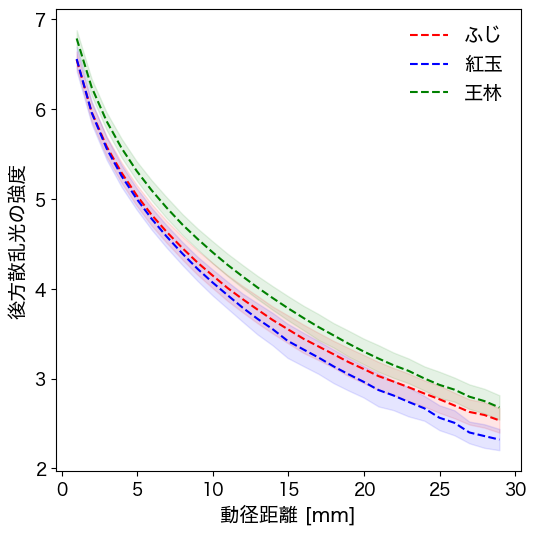

In [4]:
fig = plt.figure(figsize=(6,6))
plt.plot(distance_eq,fuji_profile,label='ふじ',color='r',linestyle='dashed')
plt.plot(distance_eq,kougyoku_profile,label='紅玉',color='b',linestyle='dashed')
plt.plot(distance_eq,ourin_profile,label='王林',color='g',linestyle='dashed')

ALPHA = 0.1
plt.fill_between(distance_eq,(fuji_profile - fuji_std),(fuji_profile + fuji_std),color='r',alpha=ALPHA)
plt.fill_between(distance_eq,(kougyoku_profile - kougyoku_std),(kougyoku_profile + kougyoku_std),color='b',alpha=ALPHA)
plt.fill_between(distance_eq,(ourin_profile - ourin_std),(ourin_profile + ourin_std),color='g',alpha=ALPHA)

plt.xticks(fontsize=12)
plt.xlabel('動径距離 [mm]',fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('後方散乱光の強度',fontsize=14)
plt.legend(frameon=False,fontsize=14)

fig.savefig('./../output/図25_プロファイルの品種差比較.png',dpi=400)

## 貯蔵の比較

In [5]:
# もとのデータのカラムから品種の情報のみ抽出
sep_cult_storage = lambda x:x[:-4]
temp = pd.DataFrame(apple_smooth_eq.columns.tolist())
temp = temp.applymap(sep_cult_storage).values.ravel()

# カラムが品種情報のみのdfを作成
apple_df =apple_smooth_eq.copy()
apple_df.columns = temp

# 品種と貯蔵期間を分けたカラムを作成
temp = apple_df.T.reset_index()
sep_cult = lambda x: x[-2:]
sep_storage = lambda x:x[:-3]

cult = pd.DataFrame(temp['index']).applymap(sep_cult)
stor = pd.DataFrame(temp['index']).applymap(sep_storage)
temp = pd.concat([cult,stor,temp],axis=1)

# 各品種ごとに分割
fuji_profile = temp[temp.iloc[:,1] == 'Fuji']
kougyoku_profile = temp[temp.iloc[:,1] == 'Kougyoku']
ourin_profile = temp[temp.iloc[:,1] == 'Ourin']

# 各貯蔵期間ごとの平均プロファイルを格納
temp_fuji = pd.DataFrame()
temp_kougyoku = pd.DataFrame()
temp_ourin = pd.DataFrame()

for i_cult in ['Fuji','Kougyoku','Ourin']:
    for i_stor in ['01','02','03','04','06','07','08','09','10','11','12']:
        
        i_temp = temp[temp.iloc[:,1] == i_cult]
        i_temp = i_temp[i_temp.iloc[:,0] == i_stor]
        i_temp = i_temp.iloc[:,3:].mean(axis=0) # 各貯蔵期間の平均プロファイル作成
        i_temp.columns = [i_stor]
        
        if i_cult == 'Fuji':
            temp_fuji = pd.concat([temp_fuji,i_temp],axis=1)
            
        elif i_cult == 'Kougyoku':
            temp_kougyoku = pd.concat([temp_kougyoku,i_temp],axis=1)
        else:
            temp_ourin = pd.concat([temp_ourin,i_temp],axis=1)
    
    


/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_83864/2353846085.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp = temp.applymap(sep_cult_storage).values.ravel()
/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_83864/2353846085.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cult = pd.DataFrame(temp['index']).applymap(sep_cult)
/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_83864/2353846085.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stor = pd.DataFrame(temp['index']).applymap(sep_storage)


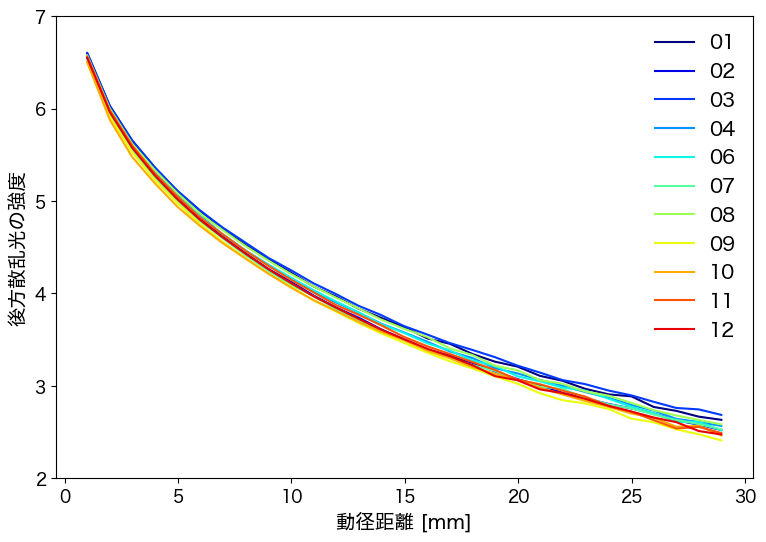

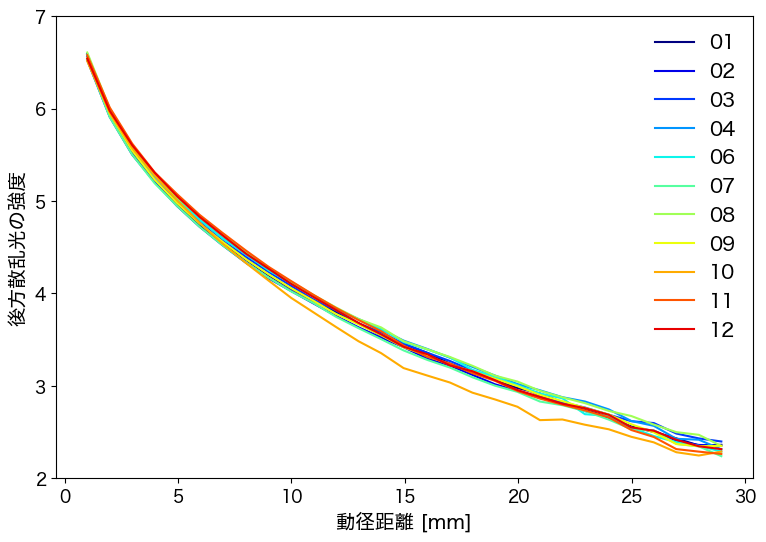

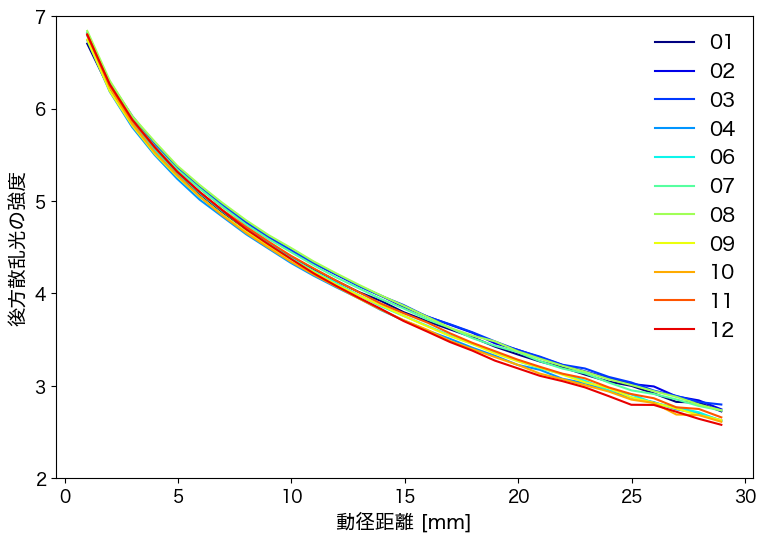

In [6]:
fig = plt.figure(figsize=(9,6))
for i,i_stor in zip(range(11),['01','02','03','04','06','07','08','09','10','11','12']):
    plt.plot(distance_eq,temp_fuji.iloc[:,i],color=plt.cm.jet(i/11),label=i_stor)
plt.legend(frameon=False)
plt.xticks(fontsize=12)
plt.xlabel('動径距離 [mm]',fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('後方散乱光の強度',fontsize=14)
plt.legend(frameon=False,fontsize=14)
plt.ylim(2,7)
fig.savefig(f'./../output/図22_ふじ_貯蔵差比較.png',dpi=400)

fig = plt.figure(figsize=(9,6))
for i,i_stor in zip(range(11),['01','02','03','04','06','07','08','09','10','11','12']):
    plt.plot(distance_eq,temp_kougyoku.iloc[:,i],color=plt.cm.jet(i/11),label=i_stor)
plt.legend(frameon=False)
plt.xticks(fontsize=12)
plt.xlabel('動径距離 [mm]',fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('後方散乱光の強度',fontsize=14)
plt.legend(frameon=False,fontsize=14)
plt.ylim(2,7)
fig.savefig(f'./../output/図23_紅玉_貯蔵差比較.png',dpi=400)

fig = plt.figure(figsize=(9,6))
for i,i_stor in zip(range(11),['01','02','03','04','06','07','08','09','10','11','12']):
    plt.plot(distance_eq,temp_ourin.iloc[:,i],color=plt.cm.jet(i/11),label=i_stor)
plt.legend(frameon=False)
plt.xticks(fontsize=12)
plt.xlabel('動径距離 [mm]',fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('後方散乱光の強度',fontsize=14)
plt.legend(frameon=False,fontsize=14)
plt.ylim(2,7)
fig.savefig(f'./../output/図24_王林_貯蔵差比較.png',dpi=400)

## Farrell式の吸収係数で確認

In [7]:
# Farrell式
temp = pd.DataFrame()
def farrell_eq(x, u_s, u_a):

    a_prime = u_s/(u_a+u_s)
    u_eff = np.sqrt(3*u_a*(u_a*u_s))
    u_t = u_a +u_s
    n_r = 1.35
    r_d = -1.44*(1/n_r**2) + 0.710*(1/n_r) + 0.668 + 0.063*n_r
    A = (1+r_d)/(1-r_d)
    r_1 = np.sqrt((1/u_t)**2 + x**2)
    r_2 = np.sqrt((1/u_t + 4*A/(3*u_t))**2 + x**2)

    return (a_prime/(4*np.pi))*((1/u_t)*(u_eff+1/r_1)*np.exp(-1*u_eff*r_1)/(r_1**2)) + ((1/u_t + 4*A/(3*u_t))*(u_eff+1/r_2)*np.exp(-1*u_eff*r_2)/(r_2**2))

# 散乱データのlogをとる,正規化する

for i_col in apple_smooth.columns:

    intensity = apple_smooth[i_col]
    profile = 10**(intensity)
    profile_norm = profile/profile.max()

    # 欠損値補間（線形補間）
    profile_norm = profile_norm.interpolate(method='linear')

    eff, cov = curve_fit(farrell_eq,
                     distance_smooth,
                     profile_norm,
                     maxfev=20000,
                     bounds=(tuple([0 for i in range(2)]),
                             tuple([np.inf for i in range(2)])
                            )
                    )
    profile_esti = farrell_eq(distance_smooth, eff[0],eff[1])
    profile_esti = profile_esti/profile_esti.max()

    r2 = r2_score(profile_norm,profile_esti)
    u_a = eff[1]
    u_s = eff[0]

    temp2 = pd.DataFrame([r2,u_a,u_s],columns = [i_col],index=['R2','u_a','u_s'])
    temp = pd.concat([temp,temp2],axis=1)

In [8]:
sep_cult_storage = lambda x:x[:-7]
a = pd.DataFrame(temp.columns.tolist())
a = a.applymap(sep_cult_storage).values.ravel()

# # カラムが品種情報のみのdfを作成
# apple_df =apple_smooth_eq.copy()
# apple_df.columns = temp

temp = temp.T.reset_index()
# temp

# sep_cult = lambda x: x[-2:]
# sep_storage = lambda x:x[:-3]

# cult = pd.DataFrame(temp['index']).applymap(sep_cult)
# stor = pd.DataFrame(temp['index']).applymap(sep_storage)
# temp = pd.concat([cult,stor,temp],axis=1)

# # 各品種ごとに分割
# fuji_profile = temp[temp.iloc[:,1] == 'Fuji']
# kougyoku_profile = temp[temp.iloc[:,1] == 'Kougyoku']
# ourin_profile = temp[temp.iloc[:,1] == 'Ourin']



/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_83864/3587780078.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  a = a.applymap(sep_cult_storage).values.ravel()


In [9]:
temp = pd.concat([temp,pd.DataFrame(a,columns=['cultivar'])],axis=1)

# 各品種ごとに分割
fuji_profile = temp[temp.iloc[:,-1] == 'Fuji']
kougyoku_profile = temp[temp.iloc[:,-1] == 'Kougyoku']
ourin_profile = temp[temp.iloc[:,-1] == 'Ourin']

In [10]:
print(fuji_profile['u_a'].mean(),fuji_profile['u_a'].std())
print(kougyoku_profile['u_a'].mean(),kougyoku_profile['u_a'].std())
print(ourin_profile['u_a'].mean(),ourin_profile['u_a'].std())

0.13291577180721334 0.07126527282114471
0.1618849754741625 0.11580138290394365
0.053877448397303955 0.0707297100992296


In [11]:
print(fuji_profile['u_s'].mean(),fuji_profile['u_s'].std())
print(kougyoku_profile['u_s'].mean(),kougyoku_profile['u_s'].std())
print(ourin_profile['u_s'].mean(),ourin_profile['u_s'].std())

3.2157630537817155 0.03141726926497787
3.213258375277597 0.03563990352287539
3.2312720708371674 0.06734086566166522


<BarContainer object of 3 artists>

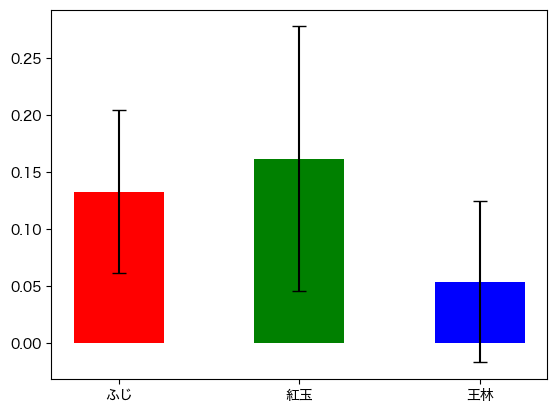

In [12]:
# plot

plt.bar(x = ['ふじ','紅玉','王林'],
        height = [fuji_profile['u_a'].mean(),kougyoku_profile['u_a'].mean(),ourin_profile['u_a'].mean()],
        yerr = [fuji_profile['u_a'].std(),kougyoku_profile['u_a'].std(),ourin_profile['u_a'].std()],
        capsize=5,
        color=['r','g','b'],
        width=0.5,)